Importing necessary Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, roc_auc_score
import math
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

Loading Dataset

In [2]:
# Load dataset
df = pd.read_csv("cardio_train.csv", sep=";")
df = df.drop(columns=["id", "gender"])  # Drop ID and gender (low Z-value per paper)

In [3]:
# Convert age from days to years
df["age"] = df["age"] // 365.25

In [4]:
df

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,168,62.0,110,80,1,1,0,0,1,0
1,55.0,156,85.0,140,90,3,1,0,0,1,1
2,51.0,165,64.0,130,70,3,1,0,0,0,1
3,48.0,169,82.0,150,100,1,1,0,0,1,1
4,47.0,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,52.0,168,76.0,120,80,1,1,1,0,1,0
69996,61.0,158,126.0,140,90,2,2,0,0,1,1
69997,52.0,183,105.0,180,90,3,1,0,1,0,1
69998,61.0,163,72.0,135,80,1,2,0,0,0,1


Data Preprocessing

In [5]:
# Preprocessing: Trim extreme values for continuous variables
continuous_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
for col in continuous_cols:
    lower = df[col].quantile(0.02)
    upper = df[col].quantile(0.98)
    df = df[(df[col] >= lower) & (df[col] <= upper)]

In [6]:
df.fillna(df.median(), inplace=True)  # Fill missing values

In [7]:
# Encode categorical variables if any
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [8]:
# Normalize numeric features
scaler = StandardScaler()
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol']
df[num_cols] = scaler.fit_transform(df[num_cols])

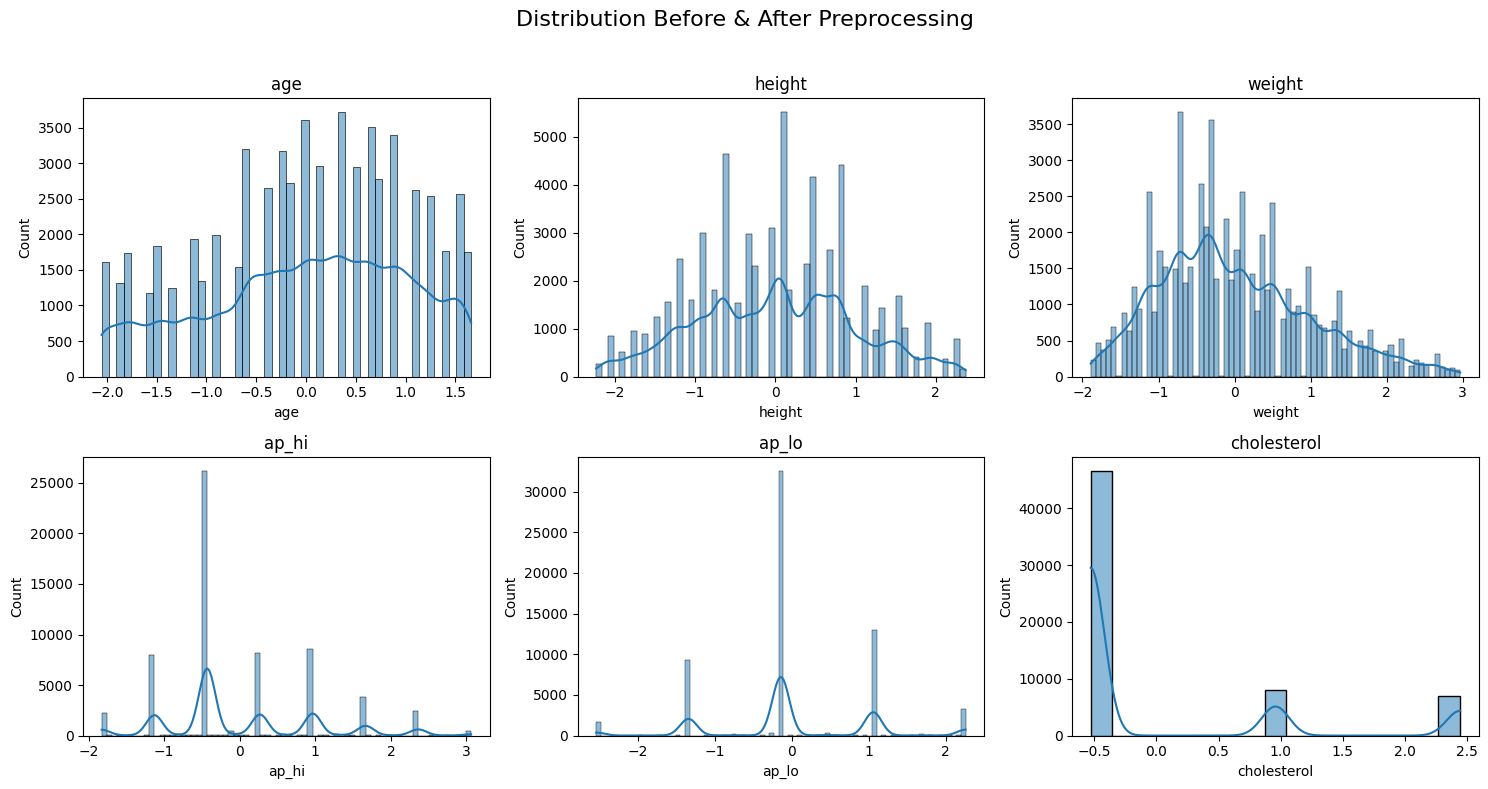

In [9]:
# Define number of columns per row
cols_per_row = 3
num_features = len(num_cols)
num_rows = math.ceil(num_features / cols_per_row)  # Calculate required rows

# Increase figure size dynamically
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(5 * cols_per_row, 4 * num_rows))  
fig.suptitle("Distribution Before & After Preprocessing", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

for i, feature in enumerate(num_cols):
    sns.histplot(df[feature], ax=axes[i], kde=True)
    axes[i].set_title(feature)

# Hide unused subplots if num_cols is not a multiple of 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.show()

 3-D graph of major variables with a mapping of the target variable

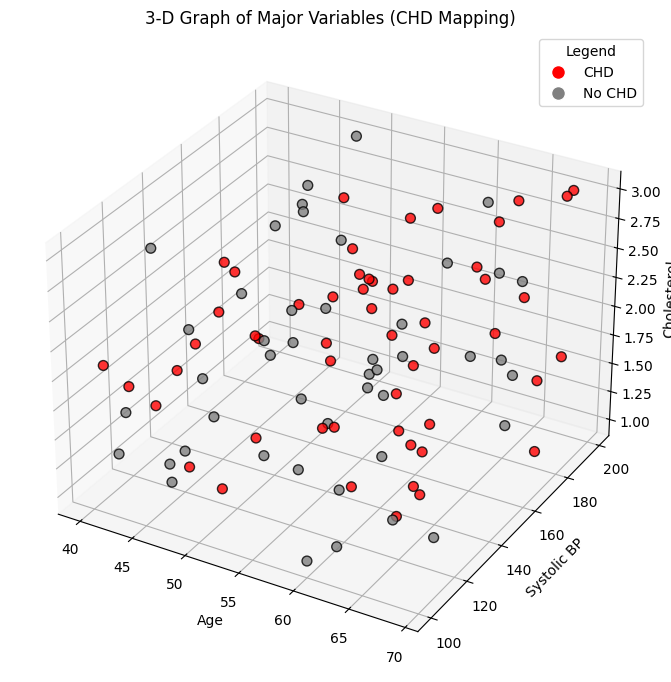

In [10]:
np.random.seed(42)
copydf = pd.DataFrame({
    'age': np.random.randint(40, 70, 100),
    'ap_hi': np.random.randint(100, 200, 100),
    'cholesterol': np.random.choice([1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00], 100),
    'cardio': np.random.choice([0, 1], 100)
})

# Create the 3D scatter plot
fig = plt.figure(figsize=(12, 8))  # Increased figure size
ax = fig.add_subplot(111, projection='3d')

# Map colors to CHD (cardio) status
colors = ['red' if label == 1 else 'gray' for label in copydf['cardio']]

# Scatter plot
scatter = ax.scatter(
    copydf['age'], copydf['ap_hi'], copydf['cholesterol'], 
    c=colors, alpha=0.8, edgecolor='k', s=50
)

# Label axes
ax.set_xlabel('Age')
ax.set_ylabel('Systolic BP')
ax.set_zlabel('Cholesterol')

# Customize ticks for the Cholesterol axis
ax.set_zticks([1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00])
ax.set_zticklabels([f"{val:.2f}" for val in [1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00]])

# Add a legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='CHD', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='No CHD', markerfacecolor='gray', markersize=10)
]
ax.legend(handles=legend_elements, loc='upper right', title='Legend')

# Add a title
plt.title('3-D Graph of Major Variables (CHD Mapping)')

# Avoid using tight_layout for 3D plots; use plt.subplots_adjust instead
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Show the plot
plt.show()

Clusters formed by systolic blood pressure

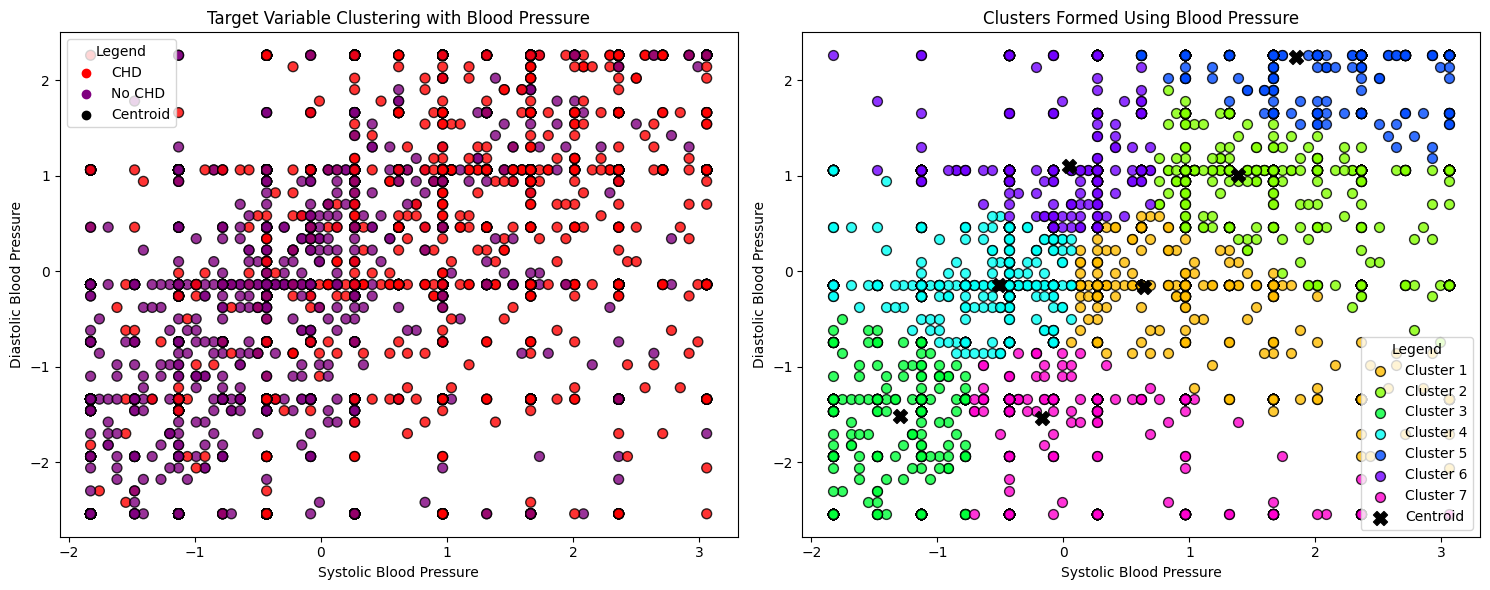

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# (A) Clustering based on Target Variable
df['cardio_color'] = df['cardio'].map({1: 'red', 0: 'purple'})  # Assign colors
axes[0].scatter(
    df['ap_hi'], df['ap_lo'],
    c=df['cardio_color'], alpha=0.8, edgecolors='k', s=50  # Fix edgecolor warning
)
axes[0].set_xlabel("Systolic Blood Pressure")
axes[0].set_ylabel("Diastolic Blood Pressure")
axes[0].set_title("Target Variable Clustering with Blood Pressure")

# Legend for CHD (Red) and No CHD (Purple)
scatter_chd = axes[0].scatter([], [], color='red', label="CHD")
scatter_no_chd = axes[0].scatter([], [], color='purple', label="No CHD")
scatter_centroid = axes[0].scatter([], [], color='black', label="Centroid")
axes[0].legend(handles=[scatter_chd, scatter_no_chd, scatter_centroid], loc='best', title="Legend")

# (B) K-Means Clustering on Blood Pressure
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)  # Ensure n_init is specified
df['cluster'] = kmeans.fit_predict(df[['ap_hi', 'ap_lo']])

# Assign 7 distinct colors for clusters
colors = sns.color_palette("hsv", 7)

for i in range(7):
    cluster_data = df[df['cluster'] == i]
    axes[1].scatter(
        cluster_data['ap_hi'], cluster_data['ap_lo'],
        label=f'Cluster {i+1}', color=colors[i], alpha=0.8, edgecolors='k', s=50
    )

# Plot Centroids
axes[1].scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    color='black', label='Centroid', marker='X', s=100
)

axes[1].set_xlabel("Systolic Blood Pressure")
axes[1].set_ylabel("Diastolic Blood Pressure")
axes[1].set_title("Clusters Formed Using Blood Pressure")
axes[1].legend(loc='best', title="Legend")

# Adjust layout
plt.tight_layout()
plt.show()

Attributes of data post pre-processing

In [12]:
# Extract ranges or unique values from the preprocessed DataFrame
summary_table = [
    ["1", "Age", f"{df['age'].min():.2f} to {df['age'].max():.2f}"],
    ["2", "Height", f"{df['height'].min():.2f} to {df['height'].max():.2f}"],
    ["3", "Weight", f"{df['weight'].min():.2f} to {df['weight'].max():.2f}"],
    ["4", "Sex", "Binary"],
    ["5", "Systolic Blood Pressure", f"{df['ap_hi'].min():.2f} to {df['ap_hi'].max():.2f}"],
    ["6", "Diastolic Blood Pressure", f"{df['ap_lo'].min():.2f} to {df['ap_lo'].max():.2f}"],
    ["7", "Cholesterol", ", ".join([f"{val:.2f}" for val in sorted(df['cholesterol'].unique())])],
    ["8", "Glucose", ", ".join([f"{val}" for val in sorted(df['gluc'].unique())]) if 'gluc' in df.columns else "N/A"],
    ["9", "Smoking", "Binary"],
    ["10", "Alcohol Intake", "Binary"],
    ["11", "Physical Activity", "Binary"],
    ["12", "Cardiovascular Disease", "Binary"],
]

# Convert the summary table into a Pandas DataFrame for neat formatting
table_df = pd.DataFrame(summary_table, columns=["Sr. No", "Attribute Name", "Range or Values"])

# Display the table
print("Table 1: Attributes of Data Post-Preprocessing\n")
print(table_df.to_string(index=False))

Table 1: Attributes of Data Post-Preprocessing

Sr. No           Attribute Name   Range or Values
     1                      Age     -2.05 to 1.66
     2                   Height     -2.23 to 2.37
     3                   Weight     -1.89 to 2.97
     4                      Sex            Binary
     5  Systolic Blood Pressure     -1.83 to 3.06
     6 Diastolic Blood Pressure     -2.54 to 2.26
     7              Cholesterol -0.53, 0.96, 2.44
     8                  Glucose           1, 2, 3
     9                  Smoking            Binary
    10           Alcohol Intake            Binary
    11        Physical Activity            Binary
    12   Cardiovascular Disease            Binary


LASSO feature Selection

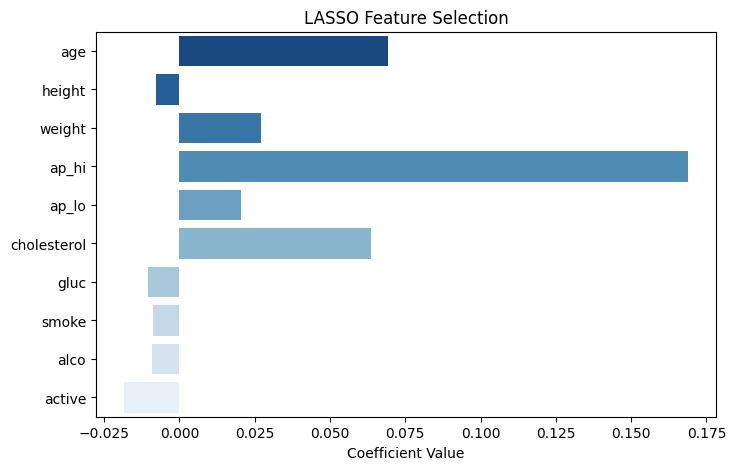

In [13]:
# Define features and target

X = df.drop(columns=['cardio', 'cluster', 'cardio_color'])  # Exclude target and unnecessary columns
y = df['cardio']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply LassoCV
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

# Extract selected features
lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)
selected_features = lasso_coefficients[lasso_coefficients != 0].index.tolist()
X = X[selected_features]
# Plot Figure 4: LASSO Feature Selection Results
plt.figure(figsize=(8, 5))
sns.barplot(
    x=lasso_coefficients[selected_features],
    y=selected_features,
    hue=selected_features,  # Assign features to hue
    palette='Blues_r',      # Reverse blue gradient
    dodge=False,            # Prevent overlapping hues
    legend=False            # Suppress the legend
)
plt.xlabel("Coefficient Value")
plt.title("LASSO Feature Selection")
plt.show()

Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Traditional classifiers

1. Logistic Classification

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

logistic_model = LogisticRegression(max_iter=500, solver='liblinear', random_state=42)
cv_scores = cross_val_score(logistic_model, X_train, y_train, cv=10)
print(f"Logistic Regression - 10-Fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred)*100
print(f"Final Logistic Regression Accuracy: {lr_accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression - 10-Fold CV Accuracy: 0.7227 ± 0.0063
Final Logistic Regression Accuracy: 72.00
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.79      0.74      7767
           1       0.75      0.65      0.70      7640

    accuracy                           0.72     15407
   macro avg       0.72      0.72      0.72     15407
weighted avg       0.72      0.72      0.72     15407



2. KNN

In [20]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': range(3, 21, 2)} 
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k-value for KNN: {best_k}")

knn_model = KNeighborsClassifier(n_neighbors=best_k)
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=10)
print(f"10-Fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred)*100
print(f"Final KNN Accuracy: {knn_acc:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Best k-value for KNN: 19
10-Fold CV Accuracy: 0.7157 ± 0.0049
Final KNN Accuracy: 72.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.76      0.73      7767
           1       0.74      0.68      0.71      7640

    accuracy                           0.72     15407
   macro avg       0.72      0.72      0.72     15407
weighted avg       0.72      0.72      0.72     15407



3. Decision Tree 

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=10)
print(f"10-Fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred)*100
print(f"Final Decision Tree Accuracy: {dt_acc:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

10-Fold CV Accuracy: 0.7255 ± 0.0044
Final Decision Tree Accuracy: 72.70%
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      7767
           1       0.76      0.66      0.70      7640

    accuracy                           0.73     15407
   macro avg       0.73      0.73      0.73     15407
weighted avg       0.73      0.73      0.73     15407



4. SVC 

In [22]:
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', random_state=42)
cv_scores = cross_val_score(svc_model, X_train, y_train, cv=10)
print(f"SVC - 10-Fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
svc_acc = accuracy_score(y_test, y_pred)*100
print(f"Final SVC Accuracy: {svc_acc:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

SVC - 10-Fold CV Accuracy: 0.7211 ± 0.0056
Final SVC Accuracy: 71.76%
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.82      0.75      7767
           1       0.77      0.61      0.68      7640

    accuracy                           0.72     15407
   macro avg       0.73      0.72      0.71     15407
weighted avg       0.73      0.72      0.71     15407



5. Gaussian Naive 
Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
cv_scores = cross_val_score(nb_model, X_train, y_train, cv=10)
print(f"10-Fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, y_pred)*100
print(f"Final Naïve Bayes Accuracy: {nb_acc:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

10-Fold CV Accuracy: 0.7127 ± 0.0050
Final Naïve Bayes Accuracy: 70.85%
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.81      0.74      7767
           1       0.76      0.60      0.67      7640

    accuracy                           0.71     15407
   macro avg       0.72      0.71      0.70     15407
weighted avg       0.72      0.71      0.71     15407



Dense neural network 

1. MLP

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

Y = pd.get_dummies(y)  # Convert target to categorical (One-Hot Encoding)

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=42)

# Define Model
model = Sequential([
    Input(shape=(xtrain.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),  # Reduced dropout

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(2, activation='softmax')  # Fixed activation
])

# Compile Model
optimizer = Adam(learning_rate=0.001)  # Lower learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Train Model
history = model.fit(xtrain, ytrain, epochs=50, batch_size=32, validation_data=(xtest, ytest), verbose=1)

# Evaluate Model
y_pred_prob = model.predict(xtest)
y_pred = y_pred_prob.argmax(axis=1)  # Convert probabilities to class labels

# Convert y_test back to labels
y_test_labels = ytest.idxmax(axis=1)
mlp_accuracy = accuracy_score(y_test_labels, y_pred)*100

print(f"\nFinal MLP Accuracy: {mlp_accuracy:.2f}%")
print("\nClassification Report:", classification_report(y_test_labels, y_pred))

Epoch 1/50
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.6854 - loss: 0.6489 - val_accuracy: 0.7274 - val_loss: 0.5612
Epoch 2/50
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7217 - loss: 0.5635 - val_accuracy: 0.7272 - val_loss: 0.5544
Epoch 3/50
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7207 - loss: 0.5628 - val_accuracy: 0.7287 - val_loss: 0.5608
Epoch 4/50
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7225 - loss: 0.5617 - val_accuracy: 0.7276 - val_loss: 0.5512
Epoch 5/50
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7267 - loss: 0.5565 - val_accuracy: 0.7298 - val_loss: 0.5553
Epoch 6/50
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7262 - loss: 0.5565 - val_accuracy: 0.7254 - val_loss: 0.5528
Epoch 7/50
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7237 - loss: 0.5560 - val_accuracy: 0.7266 - val_loss: 0.5527
Epoch 8/50
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7291 - loss: 0

Ensemble techniques

1. Boosting

In [25]:
import warnings
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Suppress XGBoost warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Gradient Boosting Classifier
gbc_model = GradientBoostingClassifier(n_estimators=150, random_state=42)
gbc_model.fit(X_train, y_train)

# XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=150, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

# AdaBoost Classifier
ada_model = AdaBoostClassifier(n_estimators=150, random_state=42)
ada_model.fit(X_train, y_train)

# Evaluate Boosting Models
boosting_models = {
    "Gradient Boosting": gbc_model,
    "XGBoost": xgb_model,
    "AdaBoost": ada_model,
}

boosting_results = {}
for name, model in boosting_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    boosting_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
    }

# Print results
print(pd.DataFrame(boosting_results).T.round(3))

                   Accuracy  Recall  Precision  F1 Score    AUC
Gradient Boosting     0.731   0.683      0.752     0.716  0.795
XGBoost               0.725   0.671      0.749     0.708  0.785
AdaBoost              0.723   0.633      0.768     0.694  0.790
